# Association of inversion and defense systems - the pipeline

In [ ]:
!pip freeze > python_requirements.txt

## Data selection and extraction

### Downloading genomes


Used python_requirements.txt file with requirements for all python code in ~/code/environments/

Selection of unique genome IDs from Chanin et. al Supplement table 41586_2024_7970_MOESM6_ESM (list 1):

In [ ]:
unique_ids = set()

with open("invertonID.txt", "r") as file:
    for line in file:
        id_ranges = line.strip()
        genome_id, _ = id_ranges.split(':')
        unique_ids.add(genome_id)

unique_id_list = list(unique_ids)

with open("invertonID_unique.txt", "w") as output_file:
    for unique_id in unique_id_list:
        output_file.write(unique_id + "\n")


Script for downloading genomes from NCBI:

In [ ]:
#!/usr/bin/env python3
import os
import time
from Bio import Entrez

Entrez.email = "YOUREMAIL@gmail.com"

output_folder = "entrez_req"

with open("invertonID_unique.txt", "r") as file:
    for line in file:
        genome_id = line.strip()
        fasta_file_path = os.path.join(output_folder, f"{genome_id}.fasta")

        if os.path.exists(fasta_file_path):
            print(f"Файл {fasta_file_path} уже существует. Пропускаем загрузку для ID {genome_id}.")
            continue

        handle = Entrez.efetch(db="nucleotide", id=genome_id, rettype="fasta", retmode="text")
        genome_sequence = handle.read()
        handle.close()

        with open(fasta_file_path, "w") as output_handle:
            output_handle.write(genome_sequence)

        time.sleep(5)

Additional chuck of code for searching and downloading missed genomes:

In [ ]:
import os

input_folder = "entrez_req"  # Папка, где находятся FASTA-файлы
id_list_file = "invertonID_unique.txt"  # Файл со списком ID
missing_ids_file = "missing_ids.txt"  # Файл для записи ID, для которых не найдены FASTA

with open(missing_ids_file, "w") as missing_ids:
    with open(id_list_file, "r") as file:
        for line in file:
            genome_id = line.strip()
            fasta_file_path = os.path.join(input_folder, f"{genome_id}.fasta")

            if not os.path.isfile(fasta_file_path):
                missing_ids.write(genome_id + "\n")


Concatenated all the sequences into one file with  ```cat dir/*.fna > concatenated.fna```

### Extracting 40 kb fragments

Selection of unique genome IDs from Chanin et. al Supplement table 41586_2024_7970_MOESM6_ESM (list 1). Extracted begining and end coordinated of invertons, converted into 40kb fragment coordinates.

In [ ]:
awk -F '[: -]' '{start=$2+20000; end=$5+20000; print $1, start, end}' ids_coords_raw.txt > coords.txt # ids_coords_raw.txt - стол6ик из 41586_2024_7970_MOESM6_ESM(1) sheet 1
awk -F '[: -]' '{start=$2-20000; end=$5+20000; if (start < 0) start = 0; print $1, start, end}' ids_coords_raw.txt > coords.txt

In [ ]:
wc -l coords.txt
17550 coords.txt
sort coords.txt | uniq > cooreds_uniq.txt
wc -l cooreds_uniq.txt
4622 cooreds_uniq.txt

Cut 40 kb fragments from downloaded genomes.

Used python_requirements.txt file with requirements for all python code in ~/code/environments/

In [ ]:
from Bio import SeqIO

def extract_fragments(coords_file, fasta_file, output_file):
    sequences = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

    with open(coords_file, 'r') as coords, open(output_file, 'w') as output:
        for line in coords:
            parts = line.strip().split()
            if len(parts) != 3:
                print(f"Пропущена строка с неправильным форматом: {line}")
                continue

            seq_id, start, end = parts
            start = int(start)
            end = int(end)

            if seq_id in sequences:
                fragment = sequences[seq_id].seq[start - 1:end]
                new_header = f">{seq_id}_{start}_{end}"
                output.write(f"{new_header}\n{fragment}\n")
            else:
                print(f"Последовательность с ID {seq_id} не найдена в FASTA-файле.")

In [ ]:
coords_file = "../cooreds_uniq.txt"
fasta_file = "../isolates_combined.fasta"
output_file = "../isolates_combined_cut_3.fasta" # с 1 координатой 6ольше нуля

extract_fragments(coords_file, fasta_file, output_file)

I checked by extracting the cut fragments for one genome and searching for them in the genome itself - everything seems ok.

## Annotation

### Integrase search

In InterPro, I pulled out tsv files on request for integrase and transposase.

In [ ]:
grep -o '^[^\t]*' ./SearchResults-integrase.tsv > accs_int.txt
awk '/[0-9]/' accs_int.txt > filtered_accs_int.txt
sed 's/ .*//' filtered_accs_int.txt > final_accs_int.txt
awk '/[0-9]/' final_accs_int.txt > ffif.txt
awk -F '\t' '{gsub(/\$/, ""); print $1}' ffif.txt > accesions_integrases.txt
wc -l accesions_integrases.txt
297 accesions_integrases.txt # совпадает с исходнйо выдачей на сайте

grep -F -f accesions_integrases.txt results.txt > matched_lines.txt # все интегразы в фрагментах геномов
wc -l matched_lines.txt
266 matched_lines.txt
awk -F '\t' '{print $1}' ./intersect_deffinder_uniq.tsv > invs_wdefsys_ids.txt # вытащила защитные системы с инвертонами, только ID геномов
grep -F -f invs_wdefsys_ids.txt matched_lines.txt > if_invertases.txt

head if_invertases.txt
Phage_integrase      PF00589.27 NC_008533.2_438806_479431_19 -            3.7e-25   89.1   0.0   5.1e-25   88.6   0.0   1.2   1   0   0   1   1   1   1 Phage integrase family
Phage_int_SAM_4      PF13495.12 NC_008533.2_438806_479431_19 -             0.0077   17.0   0.1     0.022   15.6   0.1   1.8   1   0   0   1   1   1   1 Phage integrase, N-terminal SAM-like domain

wc -l if_invertases.txt
2 if_invertases.txt

#### Defense finder

Annotating with Defense finder.

In [ ]:
defense-finder run isolates_combined_cut.fasta --out-dir ./deffinder_
wc -l ./deffinder_/isolates_combined_cut_3_defense_finder_genes.tsv
701 ./deffinder_/isolates_combined_cut_3_defense_finder_genes.tsv

Selected coordinates of annotated proteins, intersected coordinate sets.

In [ ]:
awk -F'\t' 'BEGIN { OFS="\t" } NR > 1 {
    print $2, $5, $3
}' ./deffinder_/isolates_combined_cut_3_defense_finder_genes.tsv > annot_deffinder.txt'
awk -F' # ' 'BEGIN { OFS="\t" } {
    print $1, $2, $3
}' ./matched_headers_.txt > headrs_for_annot.txt'
join -1 1 -2 1 sorted_headrs_for_annot.txt sorted_annot_deffinder.txt | awk 'BEGIN { OFS="\t" } { print $1, $2, $3, $4, $5 }' > merged_file.tsv

awk -F'\t' 'BEGIN { OFS="\t" } {
    split($1, id, "_");
    base_id = id[1] "_" id[2];
    offset = id[3];
    start = $2 + offset;
    end = $3 + offset;
    print base_id, start, end, $4, $5
}' merged_file.tsv > updated_file.tsv'
wc -l updated_file.tsv
700 updated_file.tsv
wc -l intersect_deffinder.txt
27 intersect_deffinder.txt
wc -l intersect_deffinder_uniq.tsv
21 intersect_deffinder_uniq.tsv

#### Padloc

Annotating with Padloc:

In [ ]:
padloc --fna ./isolates_combined_cut.fasta --outdir ./padloc_ --cpu 4 # директорию нужно создать заранее

Selected coords of annotated proteins.

In [ ]:
awk -F',' 'BEGIN { OFS="\t" } NR > 1 {
    split($2, seqid, "_");
    start = seqid[3] + $12;
    end = seqid[3] + $13;
    print seqid[1] "_" seqid[2], start, end, $3, $6, $14
}' ./padloc_/isolates_combined_cut_3.fasta_padloc.csv > padloc_cut_2.txt'
wc -l padloc_cut_2.txt
61 padloc_cut_2.txt
wc -l padloc_cut_uniq_2.txt
58 padloc_cut_uniq_2.txt

Intersected coordinate sets.

In [ ]:
bedtools intersect -a padloc_cut_uniq_2.txt -b coords_invertons_uniq.txt -wa -wb > intersect_padloc.txt
wc -l intersect_padloc.txt
1 intersect_padloc.txt # ду6лируется с deffinder

#### Prodigal + HMMer

ORF prediction and annotation.

In [ ]:
prodigal -i isolates_combined_cut.fasta -o isolates_proteins.gbk -a isolates_proteins_prodigal.faa -p meta
hmmscan --domtblout results.txt ./Pfam/Pfam-A.hmm isolates_proteins_prodigal.faa

Extracting coordinates of annotated genes.

In [ ]:
grep "^>" ./isolates_proteins_prodigal.faa | sed 's/^>//' > isolates_proteins_coords_interm.txt
awk -F'[ #]+' '{
    split($1, a, "_");
    start_pos = a[3];
    abs_start = $2 + start_pos;
    abs_end = $3 + start_pos;
    print a[1] "_" a[2] "\t" abs_start "\t" abs_end "\t" $4 "\t" $1
}' isolates_proteins_coords_interm.txt > isolates_proteins_coords.txt
# ./isolates_proteins_prodigal.faa аннотированные продигалом 6елки в 40 к6 фрагментах fasta
wc -l isolates_proteins_coords.txt
7768 isolates_proteins_coords.txt

In [ ]:
wc -l results.txt # файл из HMM-er'а
36754 results.txt

Intersecting coordinate sets.

In [ ]:
bedtools intersect -a isolates_proteins_coords.txt -b coords_invertons_uniq.txt -wa -wb > intersect_prots.txt

In [ ]:
grep -F -f <(awk '{print $3}' intersect_prots.txt) results.txt > intersected_prots.txt
wc -l intersected_prots.txt
125 intersected_prots.txt

Aligning intersected proteins.

In [ ]:
mafft --auto top_genes_proteins.fasta > aligned_proteins.fasta

Clustering proteins.

In [ ]:
conda install -c bioconda mmseqs2
mmseqs createdb top_genes_proteins.fasta proteinsDB
mmseqs cluster proteinsDB clusterDB tmp --min-seq-id 0.8 -c 0.8 # повторила аналогичное с выровненными полседовательностями и мягким/жестким условием кластеризации, результаты одинаковые. Попро6овала с 0,3/0,7, ниже визуализация для него
mmseqs createtsv proteinsDB proteinsDB clusterDB clusters.tsv

In [ ]:
mmseqs easy-cluster top_genes_proteins.fasta clusterRes tmp --min-seq-id 0.5 -c 0.7 
awk '$1 != $2' clusterRes_cluster.tsv > real_clusters.txt
awk '{print $2}' real_clusters.txt  | sort | uniq -c | sort -nr > cluster_frequency.txt
# все по одному(

### Cluster visualization

Used python_requirements.txt file with requirements for all python code in ~/code/environments/

In [ ]:
!{sys.executable} -m pip install networkx

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
edges = []
with open("clusters.tsv", "r") as f:
    for line in f:
        id1, id2 = line.strip().split()[:2]
        if id1 != id2:
            edges.append((id1, id2))
G = nx.Graph()
G.add_edges_from(edges)
G.remove_nodes_from(list(nx.isolates(G)))

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=50,
    font_size=8,
    alpha=0.7,
    node_color="skyblue",
    edge_color="gray",
    width=0.5, 
)
plt.title("Protein clusters from MMseqs2 (excluding self-clusters)")
plt.tight_layout()
plt.savefig("protein_clusters_filtered.png", dpi=300, bbox_inches="tight")
plt.show()

Extracted the necessary sequences from clusters on 2. They are not translated by coordinates, but it is unclear by domains, many are defined, but there are no coordinates. Extracted files from Prodigal in txt, ran hmmer again.

All from cluster on 6 are shufflons, N-ternminus.

In [ ]:
hmmscan --domtblout self_double_results.txt ./Pfam/Pfam-A.hmm ./self_double.txt

## Invertons within defense genes

### Invertons within defense genes: relative location

Used python_requirements.txt file with requirements for all python code in ~/code/environments/

In [1]:
import pandas as pd

In [ ]:
pos = pd.read_csv('./intersect_deffinder_uniq.tsv', sep='\t', names=['ID', 'start_prot', 'end_prot', 'System', 'Protein', 'start_inv', 'end_inv', 'inv_pos'])


In [6]:
def get_inv_pos(row):
    if row['start_prot'] < row['start_inv'] and row['end_prot'] > row['end_inv']:
        return 'intragenic'
    elif (row['start_prot'] > row['start_inv'] and row['end_prot'] > row['end_inv']) or \
         (row['start_prot'] < row['start_inv'] and row['end_prot'] < row['end_inv']):
        return 'partial'
    else:
        return 'other'
    
pos['inv_pos'] = pos.apply(get_inv_pos, axis=1)
pos

,ID,start_prot,end_prot,System,Protein,start_inv,end_inv,inv_pos
0,NC_008533.2,458169,459449,RM_Type_I,RM__Type_I_S_52,458806,459431,intragenic
1,NZ_AP025562.1,2222668,2223846,RM_Type_I,RM__Type_I_S_06,2222646,2223287,partial
2,NZ_AP025562.1,2224929,2225591,RM_Type_I,RM__Type_I_S_06,2224906,2225588,partial
3,NZ_CP007524.1,1116391,1117461,RM_Type_II,RM_Type_II__Type_II_REase09,1117051,1117107,intragenic
4,NZ_CP007593.1,474841,476388,RM_Type_I,RM__Type_I_S_52,474698,475058,partial
5,NZ_CP007647.1,56205,58907,RM_Type_IIG,RM_Type_IIG__Type_IIG_FAM_1.einsi_trimmed,56673,56957,intragenic
6,NZ_CP011348.1,284798,285973,RM_Type_I,RM__Type_I_S_06,285303,285992,partial
7,NZ_CP011368.1,150592,151839,RM_Type_I,RM__Type_I_S_51,151107,151856,partial
8,NZ_CP011591.1,3953251,3955731,PrrC,RM__Type_I_REases_FAM_0.einsi_trimmed,3952518,3953266,partial
9,NZ_CP012196.1,1743756,1744577,RM_Type_II,RM_Type_II__Type_II_REase32,1743912,1744253,intragenic


## Work with the full genomes

In [ ]:
grep -c "RM__Type_I_S" ./deffinder_global/part1/isolates_combined.part_001_defense_finder_genes.tsv
154
grep -c "RM__Type_I_S" ./deffinder_global/part2/isolates_combined.part_002_defense_finder_genes.tsv
248
grep -c "RM__Type_I_S" ./deffinder_global/part3/isolates_combined.part_003_defense_finder_genes.tsv
253
grep -c "RM__Type_I_S" ./deffinder_global/part4/isolates_combined.part_004_defense_finder_genes.tsv
98
grep -c "RM__Type_I_S" ./deffinder_global/part5/isolates_combined.part_005_defense_finder_genes.tsv
98

In [ ]:
wc -l ./deffinder_global/part5/isolates_combined.part_005_defense_finder_genes.tsv
2155 ./deffinder_global/part5/isolates_combined.part_005_defense_finder_genes.tsv
2095 ./deffinder_global/part4/isolates_combined.part_004_defense_finder_genes.tsv
5997 ./deffinder_global/part3/isolates_combined.part_003_defense_finder_genes.tsv
5233 ./deffinder_global/part2/isolates_combined.part_002_defense_finder_genes.tsv
2904 ./deffinder_global/part1/isolates_combined.part_001_defense_finder_genes.tsv

## Pictures and graphs

Used python_requirements.txt file with requirements for all python code in ~/code/environments/

In [4]:
import matplotlib.pyplot as plt
import squarify
import numpy as np

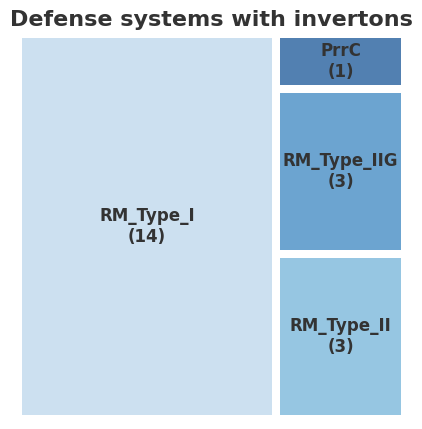

In [2]:

labels = ['RM_Type_I', '', 'RM_Type_II', '', 'RM_Type_IIG', '', 'PrrC']
sizes = [14, 0.001, 3, 0.001, 3, 0.001, 1] 

labels_with_sizes = [f"{label}\n({size})" if size != 0.001 else "" for label, size in zip(labels, sizes)]

colors = plt.cm.Blues([0.3, 0, 0.5, 0, 0.7, 0, 0.9])

plt.figure(figsize=(5, 5))
squarify.plot(
    sizes=sizes,
    label=labels_with_sizes,
    color=colors,
    alpha=0.7,
    pad=True,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'color': '#333333'}
)

plt.title('Defense systems with invertons', fontsize=16, weight='bold', color='#333333')
plt.axis('off')
plt.show()

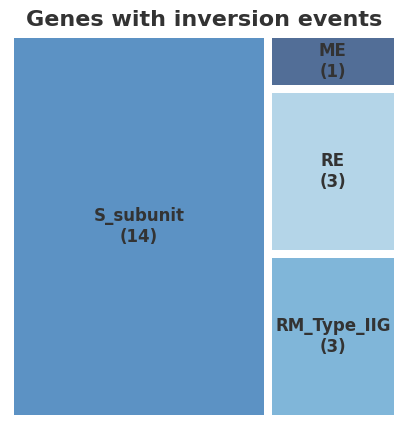

In [3]:
labels = ['S_subunit', 'RM_Type_IIG', 'RE', 'ME']
sizes = [14, 3, 3, 1]  # Количество защитных систем

labels_with_sizes = [f"{label}\n({size})" if size != 0.001 else "" for label, size in zip(labels, sizes)]

colors = plt.cm.Blues([0.8, 0.6, 0.4, 1.0])

plt.figure(figsize=(5, 5))
squarify.plot(
    sizes=sizes,
    label=labels_with_sizes,
    color=colors,
    alpha=0.7,
    pad=True,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'color': '#333333'}
)

plt.title('Genes with inversion events', fontsize=16, weight='bold', color='#333333')
plt.axis('off')
plt.show()

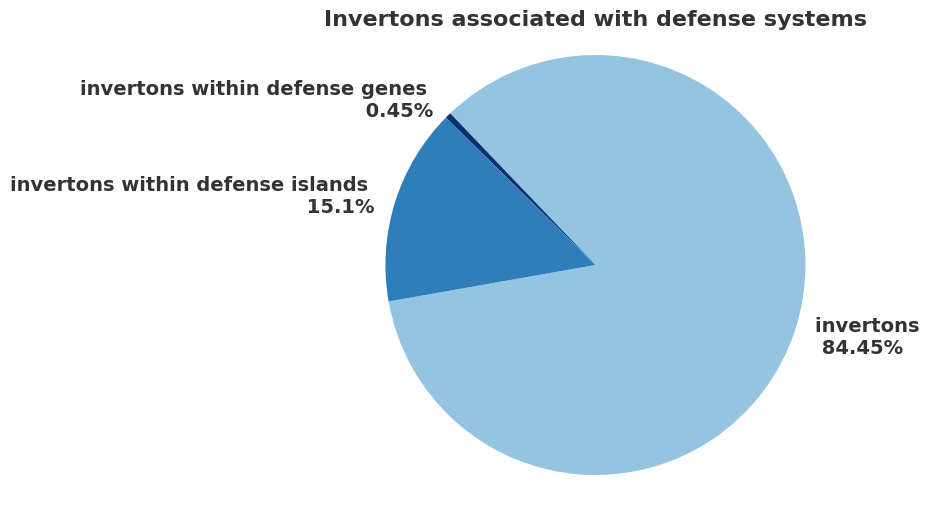

In [5]:
labels = ['invertons \n 84.45%', 'invertons within defense genes \n 0.45%', 'invertons within defense islands \n 15.1%']
sizes = [(4623-719-21)/4623*100, 21/4623*100, (719-21)/4623*100]
colors = plt.cm.Blues([0.4, 1.2, 0.7])

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=190,
    textprops={'weight': 'bold', 'fontsize': 14, 'color' : '#333333'},
    autopct=''
)

plt.title('Invertons associated with defense systems', fontsize=16, weight='bold', color='#333333')
plt.axis('equal')
plt.show()

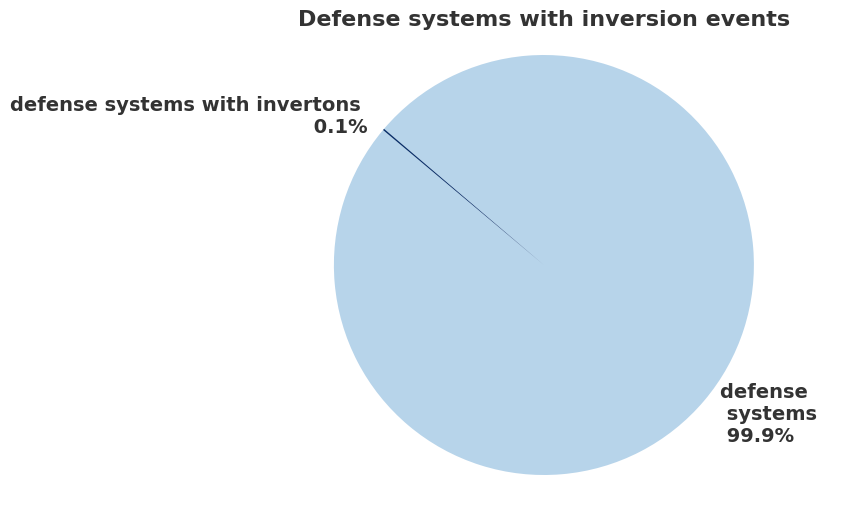

In [6]:
labels = ['defense \n systems \n 99.9%', 'defense systems with invertons \n 0.1%']
sizes = [(17569)/(17569)*100, 21/(17569)*100]
colors = plt.cm.Blues([0.3, 1.0])

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=140,
    textprops={'weight': 'bold', 'fontsize': 14, 'color' : '#333333'},
    autopct=''
)

plt.title('Defense systems with inversion events', fontsize=16, weight='bold', color='#333333')
plt.axis('equal')
plt.show()

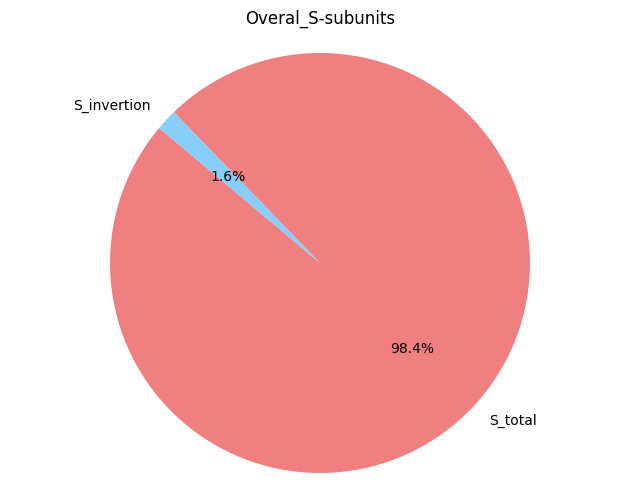

In [3]:
labels = ['S_total', 'S_invertion']
sizes = [(851-14)/851*100, 14/851*100]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',  startangle=140)
plt.title("Overal_S-subunits")
plt.axis('equal')
plt.show()

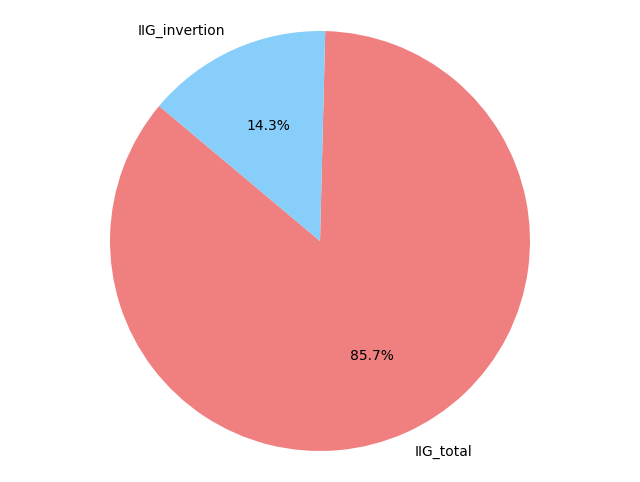

In [7]:
labels = ['IIG_total', 'IIG_invertion']
sizes = [(21-3)/21*100, 3/21*100]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',  startangle=140)

plt.axis('equal')
plt.show()

### Domain visualization - preliminary work

### Domain coordinates for proteins of interest

I pulled out the necessary 6-tree sequences from the file from Prodigal for three examples with my hands, eyes and a calculator. I ran them in hmmer (pfam_results_.domtblout results).

In [ ]:
hmmscan --cpu 8 --domtblout domains_intersected_proteins.txt ./Pfam/Pfam-A.hmm
 ./all_intersected_proteins.txt

In [ ]:
grep -v "^#" pfam_results_.domtblout  | awk '{print $1, $4, $18, $19}' > domains_coords.tsv

### Domain coordinates transformation

Used python_requirements.txt file with requirements for all python code in ~/code/environments/

In [ ]:
import pandas as pd

domains = pd.read_csv("domains_intersected_prots_coords.tsv", sep=" ", names=["domain", "protein_id", "aa_start", "aa_end"])
genes = pd.read_csv("genes_fixed_trouble.txt", sep="\t", comment='#', names=["chr", "start", "end"], header=None)

results = []
for _, row in domains.iterrows():
    gene = genes[genes["chr"] == row["protein_id"]]
    
    if gene.empty:
        print(f"Предупреждение: ген {row['protein_id']} не найден в таблице генов")
        continue
    
    gene_data = gene.iloc[0]
    dna_start = gene_data["start"] + (row["aa_start"] * 3)
    dna_end = gene_data["start"] + (row["aa_end"] * 3)

    if dna_end > gene_data["end"]:
        print(f"Предупреждение: домен {row['domain']} выходит за границы гена {row['protein_id']}")
        continue
    
    results.append({
        "chr": gene_data["chr"],
        "start": dna_start,
        "end": dna_end,
        "domain": row["domain"]
    })

result_df = pd.DataFrame(results)
result_df.to_csv("converted_domains_trouble.tsv", sep="\t", index=False, header=False)

In [2]:
result_df 

,chr,start,end,domain
0,NC_008533.2_438806_479431_17,458325,458643,Methylase_S
1,NC_008533.2_438806_479431_17,458934,459399,Methylase_S
2,NC_008533.2_438806_479431_17,458649,458766,DUF6291
3,NC_008533.2_438806_479431_17,459219,459255,DUF6291
4,NC_008533.2_438806_479431_17,458589,458664,Flagellin_C
...,...,...,...,...
118,NZ_LR698957.1_1402995_1443422_22,1422222,1422375,Fib_alpha
119,NZ_LR698957.1_1402995_1443422_22,1422858,1422984,Fib_alpha
120,NZ_LR698957.1_1402995_1443422_22,1422294,1422309,DUF5344
121,NZ_LR698957.1_1402995_1443422_22,1422762,1422798,DUF5344


## Metagenomic data

At first I honestly tried to cut by inqs into a separate file for expanding the data base, but then I realized that something was going wrong. I redid it from the beginning.

Downloaded the posted sequences: https://zenodo.org/records/7662825, combined all the records

```cat *.fasta.gz > concatenated_NEW.fasta.gz```

```zcat ./concatenated_NEW.fasta.gz | grep '^>' | cut -d ' ' -f 1 | sed 's/^>//' >> sequence_ids_fasta_gz.txt```

```awk -F '[:|-]' 'NR > 1 {print $1 "\t" $2 "\t" $3 "\t" $4 "\t" $5}' 41586_2024_7970_MOESM7.txt > contigs_cut.txt```

```cut -f 1-5 contigs_cut.txt > contigs_cutcut.txt```

```cut -f 1 ../contigs_cutcut.txt > ../ids_cut.txt```

```grep -F -x -f ../ids_cut.txt ./LR_assemblies/sequence_ids_fasta_gz.txt > what.txt```

NODE_162_length_103990_cov_16.470573

NODE_233_length_72764_cov_9.904413

NODE_261_length_67573_cov_9.838576

NODE_275_length_64110_cov_3.794661

NODE_4_length_713996_cov_35.592808

NODE_1198_length_39517_cov_1.773833

NODE_26331_length_1681_cov_2.987700

NODE_1627_length_33841_cov_70.647487

According to the contig names, there is an intersection of only these records.
